In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
from shutil import copy2
import csv

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install tensorflow_hub

In [5]:
import tensorflow_hub as hub

In [6]:
tf.__version__

'2.3.0'

In [7]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [8]:
data_root = ("/content/gdrive/My Drive/TensorFlow/handphone_photos")

In [9]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 46 images belonging to 2 classes.
Found 191 images belonging to 2 classes.


In [10]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 2))

In [11]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'cropped': 0, 'full': 1}


In [12]:
!cat labels.txt

cropped
full

In [13]:
IMAGE_SIZE = 224

In [14]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [16]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [17]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=100,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/100
6/6 [==============================] - 34s 6s/step - loss: 0.9555 - acc: 0.4764 - val_loss: 0.7680 - val_acc: 0.5000
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.8020 - acc: 0.6283 - val_loss: 0.7231 - val_acc: 0.5217
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.7490 - acc: 0.6126 - val_loss: 0.6535 - val_acc: 0.5652
Epoch 4/100
6/6 [==============================] - 7s 1s/step - loss: 0.6960 - acc: 0.6178 - val_loss: 0.6165 - val_acc: 0.7174
Epoch 5/100
6/6 [==============================] - 7s 1s/step - loss: 0.5443 - acc: 0.7277 - val_loss: 0.6185 - val_acc: 0.6739
Epoch 6/100
6/6 [==============================] - 7s 1s/step - loss: 0.5753 - acc: 0.7330 - val_loss: 0.6231 - val_acc: 0.6957
Epoch 7/100
6/6 [==============================] - 7s 1s/step - loss: 0.4799 - acc: 0.7958 - val_loss: 0.5309 - val_acc: 0.7391
Epoch 8/100
6/6 [==============================] - 8s 1s/step - loss: 0.4968 - acc: 0.7696 - val_loss: 

In [18]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 0s 240ms/step - loss: 0.2617 - acc: 0.9348
Final loss: 0.26
Final accuracy: 93.48%


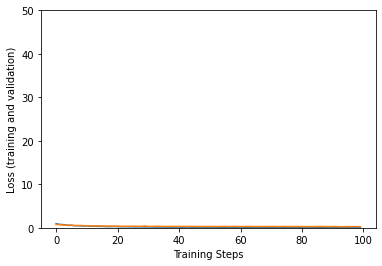

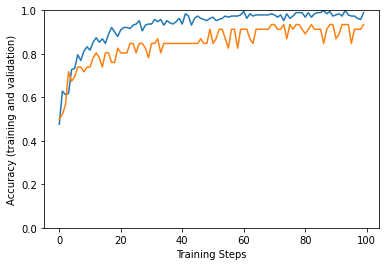

In [19]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

# Checking performance of a model

In [20]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [21]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Cropped' 'Full']


In [22]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 2)


In [23]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Full' 'Full' 'Full' 'Cropped' 'Cropped' 'Full' 'Cropped' 'Cropped'
 'Full' 'Full' 'Full' 'Cropped' 'Full' 'Cropped' 'Full' 'Full' 'Cropped'
 'Cropped' 'Cropped' 'Full' 'Cropped' 'Cropped' 'Cropped' 'Full' 'Cropped'
 'Full' 'Full' 'Full' 'Cropped' 'Cropped' 'Cropped' 'Cropped']


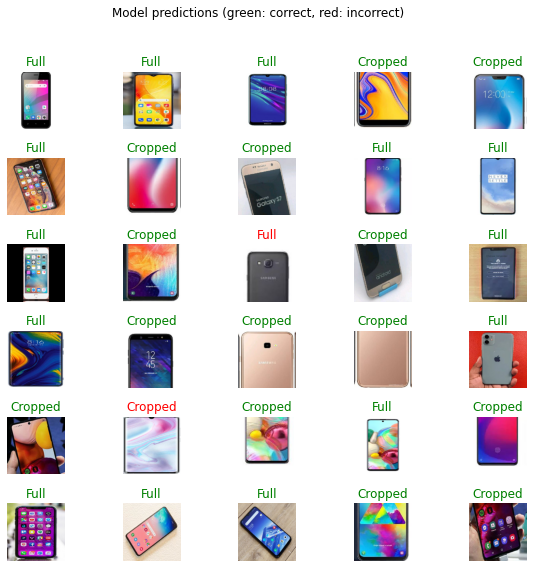

In [24]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Save Model

In [25]:
# cd into TensorFlow directory in Google Drive
%cd '/content/gdrive/My Drive/TensorFlow/'

MODEL_BASE_PATH = "model"
PROJECT_NAME = "medium_project_1"
SAVE_MODEL_NAME = "model-tfhub-mobilenet-161120.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At model/medium_project_1/model-tfhub-mobilenet-161120.h5...


#Make a Prediction

In [26]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np

# Parameters
input_size = (224,224) # customizable

# Define Input Shape (3D)
channel = (3,)
input_shape = input_size + channel

# Define Labels
labels = ['Cropped', 'Full']

In [27]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr
    
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [34]:
# Load Model
from tensorflow.keras.models import load_model
MODEL_PATH = 'model/medium_project_1/model-tfhub-mobilenet-161120.h5'
model = load_model(MODEL_PATH,custom_objects={'KerasLayer':hub.KerasLayer},compile=False)

In [35]:
#cd into the TensorFlow directory in your Google Drive
%cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


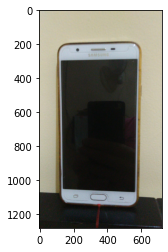

image.jpg
Full 0.98140556


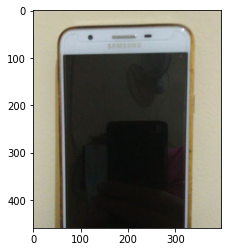

image-crop.jpg
Cropped 0.60717314


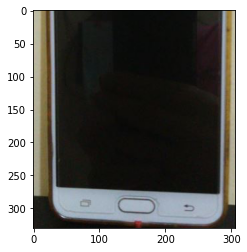

image-crop-bottom.jpg
Cropped 0.98356277


In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=['image.jpg', 'image-crop.jpg', 'image-crop-bottom.jpg']

for image_path in img:
  # read image
  im = Image.open(image_path)
  X = preprocess(im,input_size)
  X = reshape([X])
  y = model.predict(X)

  plt.imshow(im)
  plt.show()

  print(image_path)
  print( labels[np.argmax(y)], np.max(y) )